Number of time series: 23
Number of unique classes: 2
Time series length: 136
Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


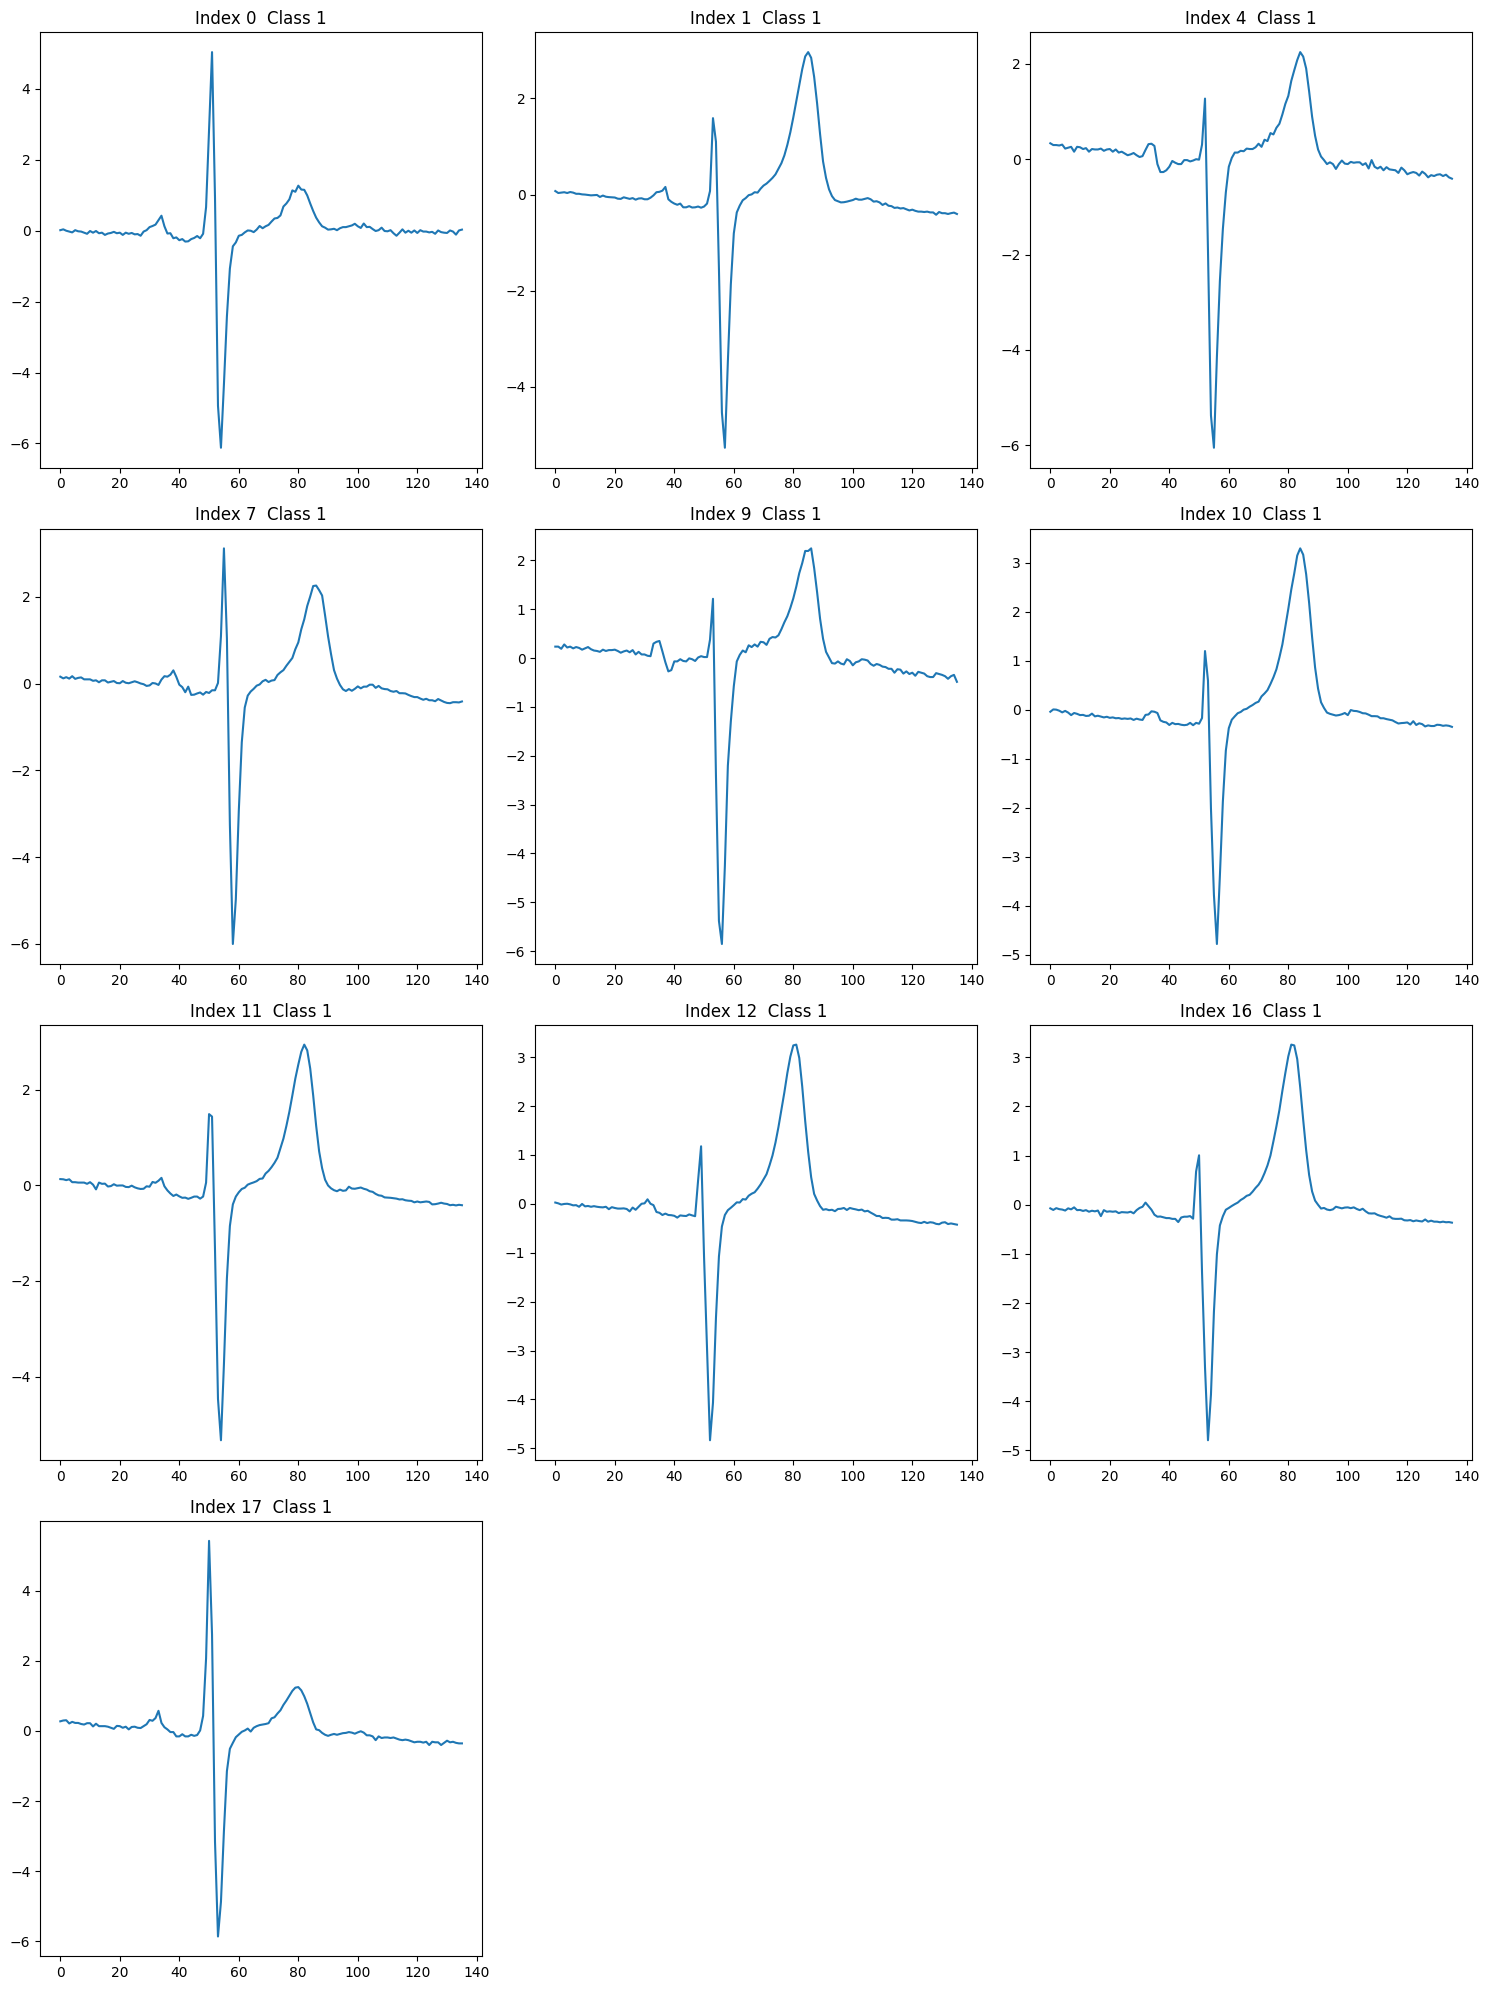

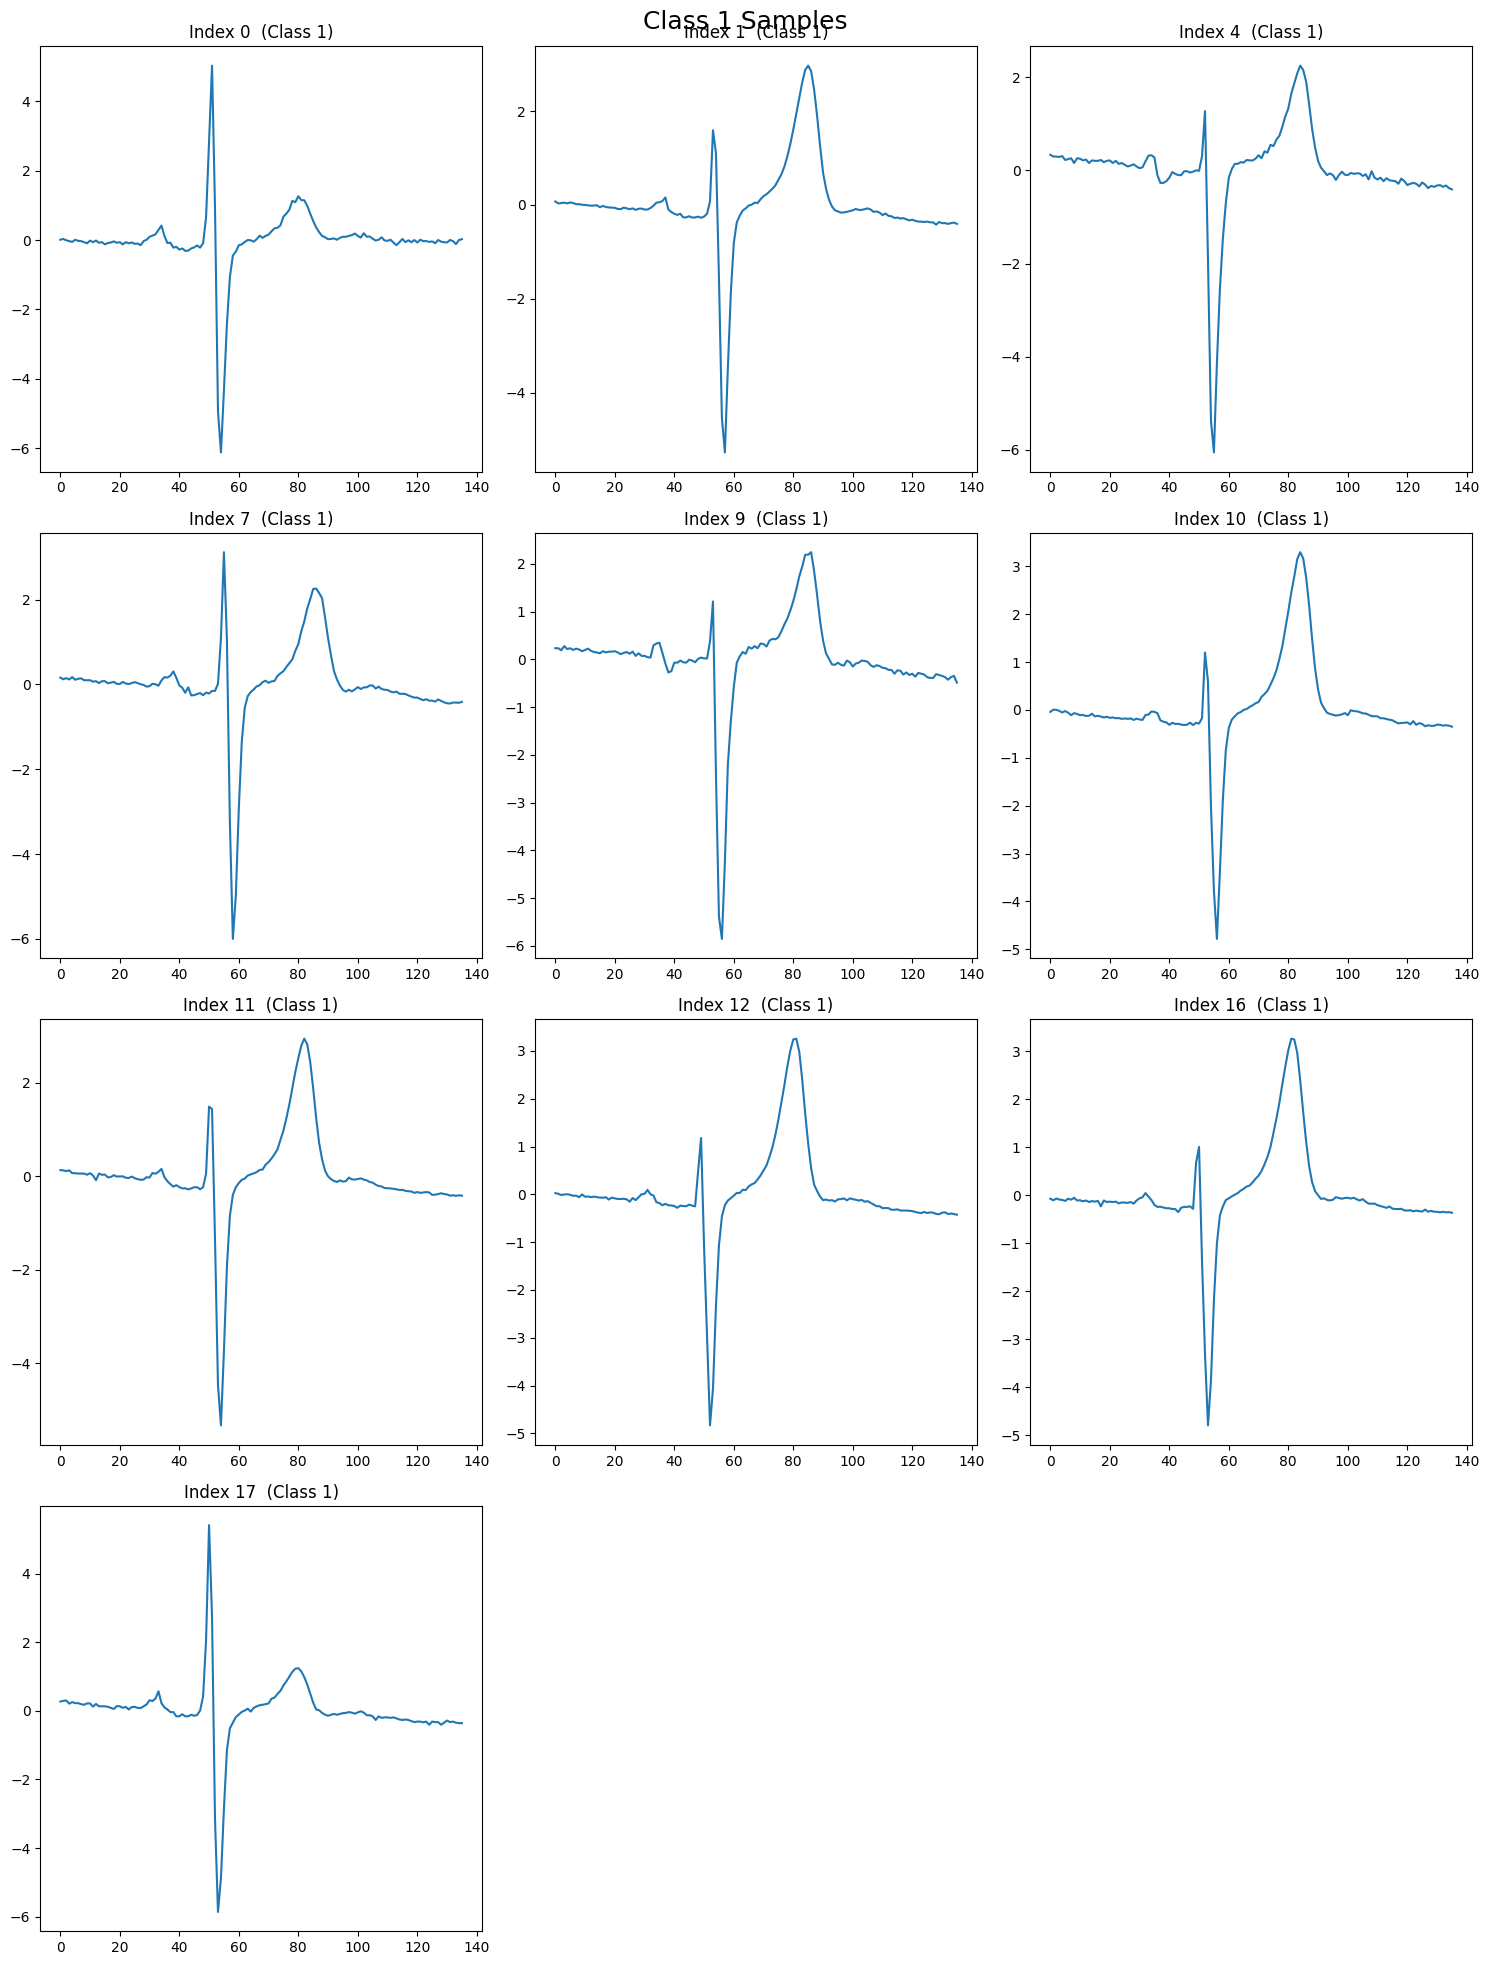

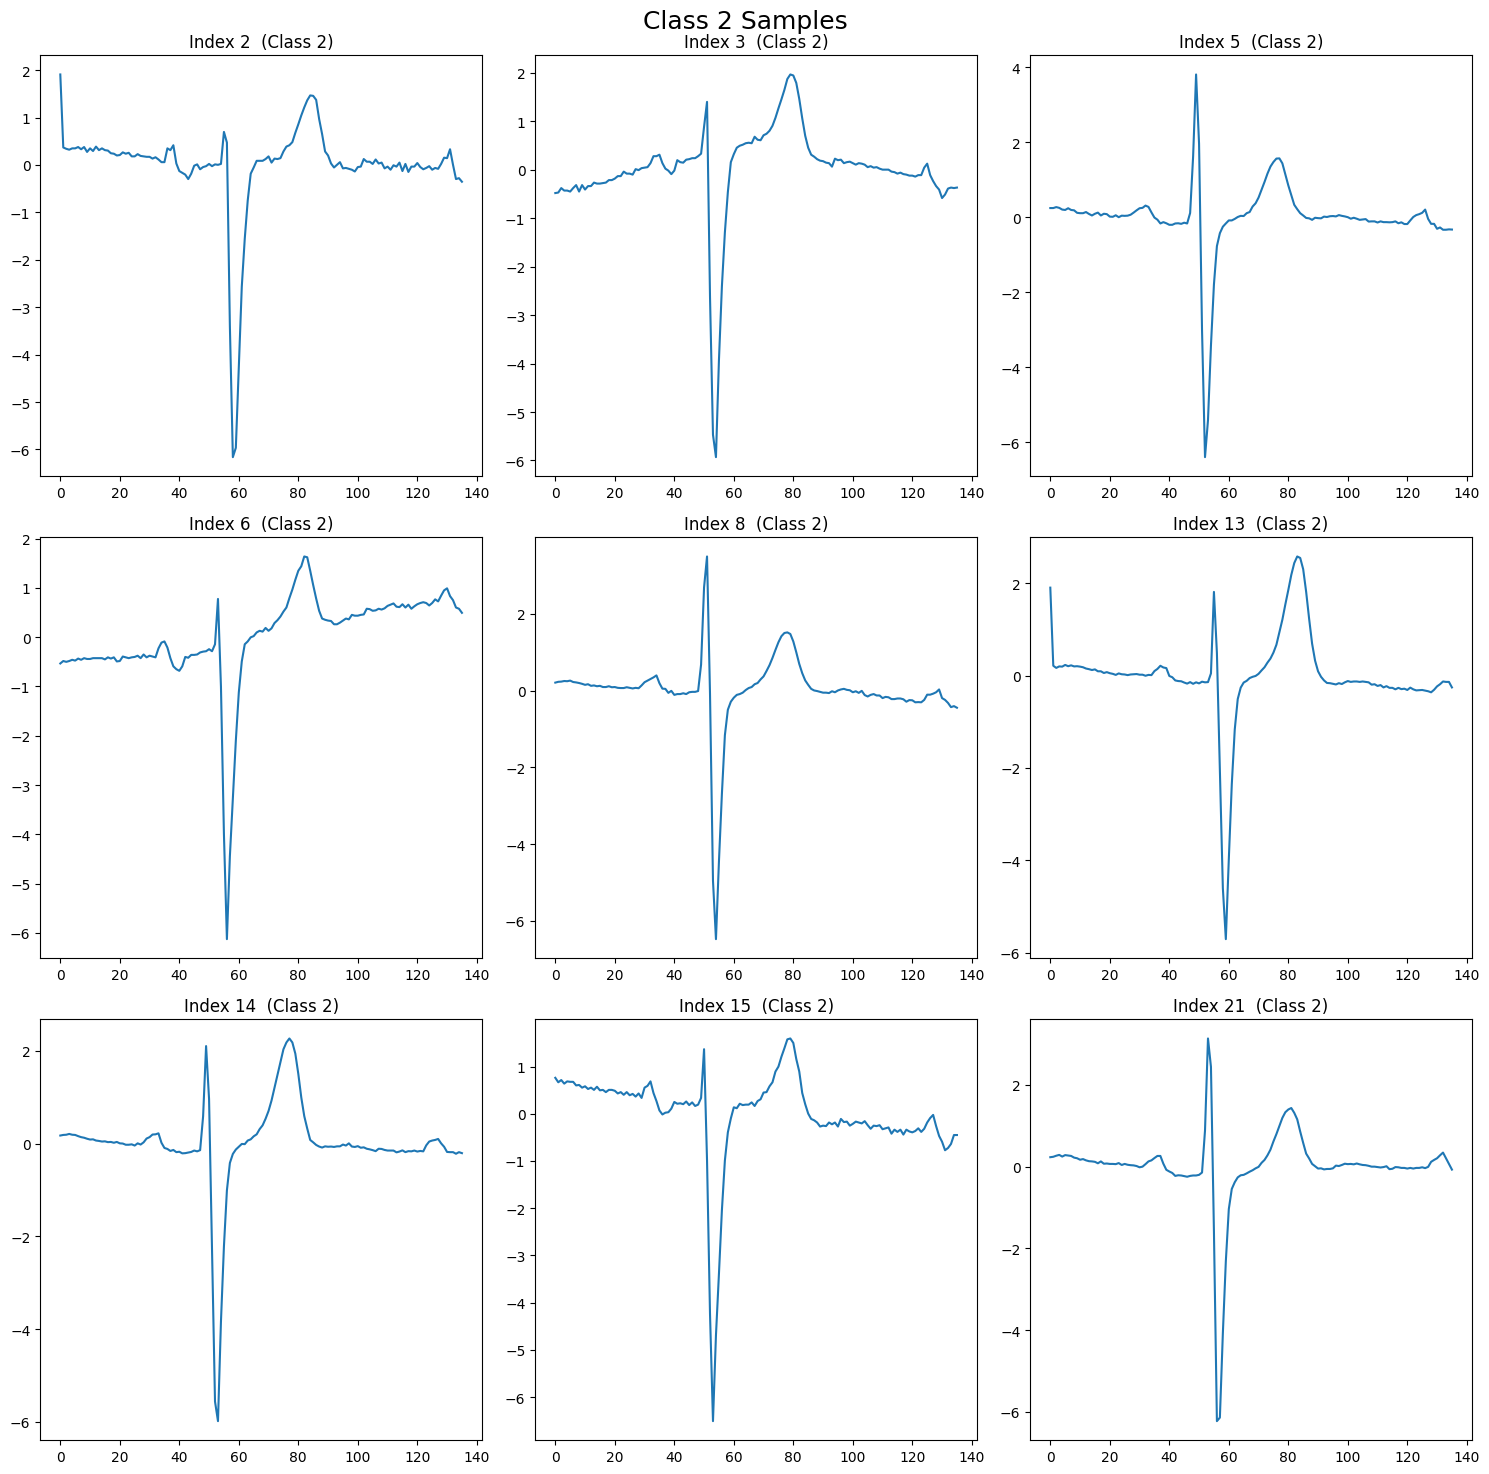

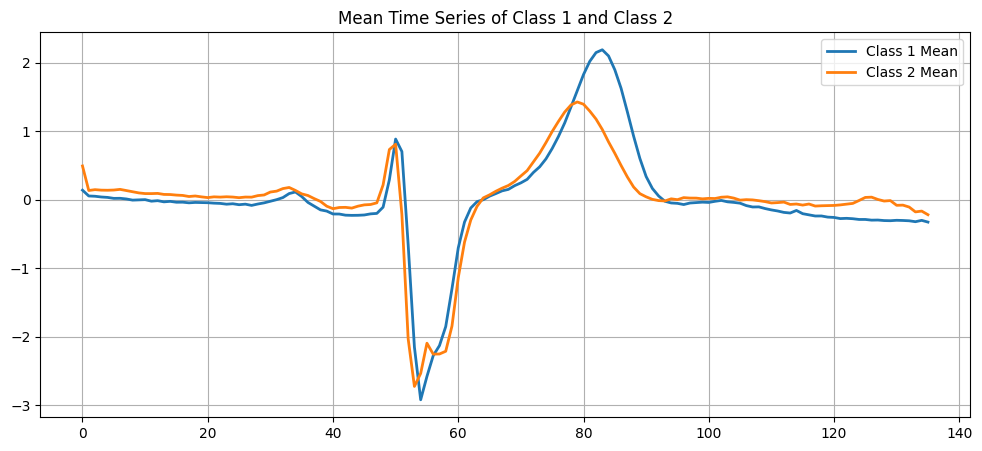

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
import hdbscan

# Load train
data_train = np.loadtxt("train.csv", delimiter=",")

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(int)      # ← 修正済み

# Load test
data_test = np.loadtxt("test.csv", delimiter=",")

X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(int)        # ← 修正済み

# Basic summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

# Number of examples in each class in the training set
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

import matplotlib.pyplot as plt
import numpy as np

# data_train の Class=1.0 の最初の10件を取り出す
indices = [i for i in range(len(data_train)) if data_train[i,0] == 1.0][:10]

n = len(indices)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(15, 5*rows))  # 横長にすると見やすい

for idx, i in enumerate(indices):
    plt.subplot(rows, cols, idx+1)
    plt.plot(data_train[i, 1:])   # クラス列を除く
    plt.title(f"Index {i}  Class {int(data_train[i,0])}")
    plt.tight_layout()

plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_class(class_label, max_plots=10):
    # 指定クラスのインデックスを取得（最大 max_plots まで）
    indices = [i for i in range(len(data_train)) if data_train[i,0] == class_label][:max_plots]

    n = len(indices)
    if n == 0:
        print(f"Class {class_label} はありません。")
        return
    
    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(15, 5*rows))
    plt.suptitle(f"Class {int(class_label)} Samples", fontsize=18)

    for idx, i in enumerate(indices):
        plt.subplot(rows, cols, idx+1)
        plt.plot(data_train[i, 1:])   # 1列目はクラスなので除外
        plt.title(f"Index {i}  (Class {int(class_label)})")
        plt.tight_layout()

    plt.show()


# ▶ Class 1 を表示
plot_class(1.0)

# ▶ Class 2 を表示
plot_class(2.0)

import numpy as np
import matplotlib.pyplot as plt

# --- クラスごとのデータ抽出（特徴量のみ） ---
class1 = data_train[data_train[:,0] == 1.0][:, 1:]
class2 = data_train[data_train[:,0] == 2.0][:, 1:]

# --- 平均（時系列平均） ---
mean1 = class1.mean(axis=0)
mean2 = class2.mean(axis=0)

# --- プロット ---
plt.figure(figsize=(12,5))
plt.plot(mean1, label="Class 1 Mean", linewidth=2)
plt.plot(mean2, label="Class 2 Mean", linewidth=2)
plt.title("Mean Time Series of Class 1 and Class 2")
plt.legend()
plt.grid(True)
plt.show()




Number of time series: 23
Number of unique classes: 2
Time series length: 136
[KMeans / euclidean] ARI(train): -0.043364158960259934
[KMeans / dtw] ARI(train): 0.04827586206896552


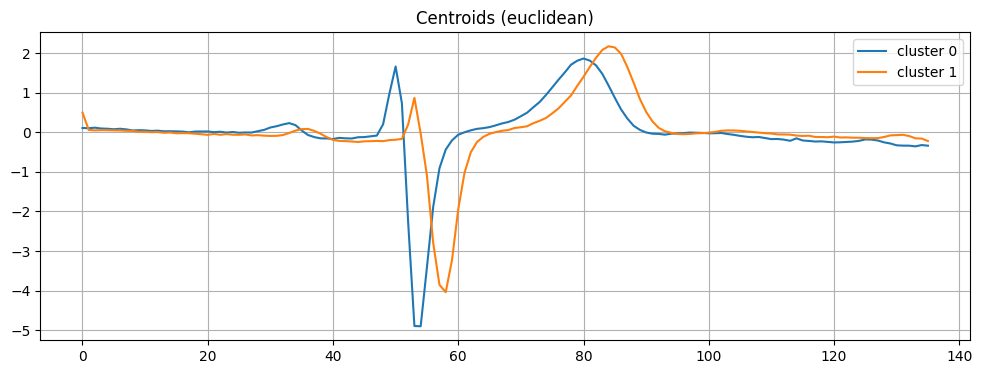

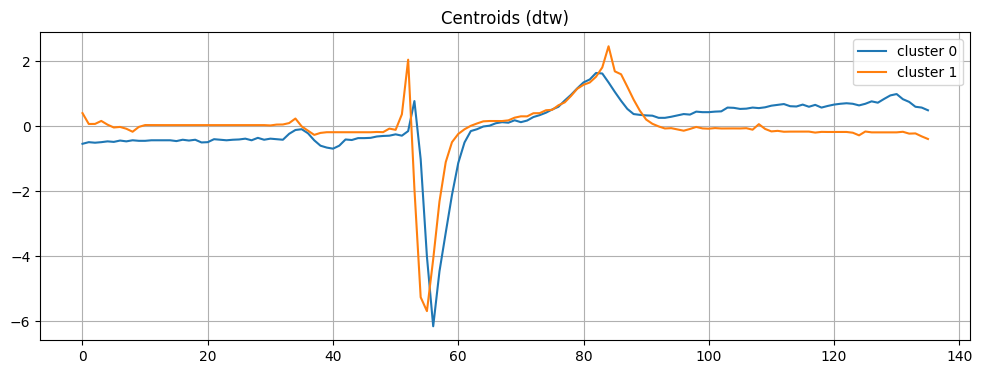

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import adjusted_rand_score

# --------------------
# Load
# --------------------
data_train = np.loadtxt("train.csv", delimiter=",")
data_test  = np.loadtxt("test.csv", delimiter=",")

y_train = data_train[:, 0].astype(int)
X_train = to_time_series_dataset(data_train[:, 1:])

y_test = data_test[:, 0].astype(int)
X_test = to_time_series_dataset(data_test[:, 1:])

print("Number of time series:", len(X_train))
print("Number of unique classes:", len(np.unique(y_train)))
print("Time series length:", X_train.shape[1])

# --------------------
# Scale (recommended)
# --------------------
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# --------------------
# TimeSeriesKMeans (Euclidean)
# --------------------
k = len(np.unique(y_train))  # 2クラス想定なら k=2
km_euc = TimeSeriesKMeans(n_clusters=k, metric="euclidean", random_state=42)
pred_train_euc = km_euc.fit_predict(X_train_s)

print("[KMeans / euclidean] ARI(train):", adjusted_rand_score(y_train, pred_train_euc))

# --------------------
# TimeSeriesKMeans (DTW)
#   ※DTWは重いので max_iter を小さめに（必要なら増やす）
# --------------------
km_dtw = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    random_state=42,
    max_iter=20
)
pred_train_dtw = km_dtw.fit_predict(X_train_s)

print("[KMeans / dtw] ARI(train):", adjusted_rand_score(y_train, pred_train_dtw))

# --------------------
# クラスタ中心（代表波形）を可視化
# --------------------
def plot_centroids(model, title):
    plt.figure(figsize=(12,4))
    for i, c in enumerate(model.cluster_centers_):
        plt.plot(c.ravel(), label=f"cluster {i}")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_centroids(km_euc, "Centroids (euclidean)")
plot_centroids(km_dtw, "Centroids (dtw)")


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import adjusted_rand_score

# --------------------
# Load
# --------------------
data_train = np.loadtxt("train.csv", delimiter=",")
data_test  = np.loadtxt("test.csv", delimiter=",")

y_train = data_train[:, 0].astype(int)
X_train = to_time_series_dataset(data_train[:, 1:])

y_test = data_test[:, 0].astype(int)
X_test = to_time_series_dataset(data_test[:, 1:])

# --------------------
# Scaling
# --------------------
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# --------------------
# KMeans: Euclidean
# --------------------
k = len(np.unique(y_train))

km_euc = TimeSeriesKMeans(n_clusters=k, metric="euclidean", random_state=42)
pred_euc = km_euc.fit_predict(X_train_s)

print("[KMeans/euclidean] ARI:", adjusted_rand_score(y_train, pred_euc))

# --------------------
# KMeans: DTW
# --------------------
km_dtw = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    max_iter=20,
    random_state=42
)
pred_dtw = km_dtw.fit_predict(X_train_s)

print("[KMeans/dtw] ARI:", adjusted_rand_score(y_train, pred_dtw))

# --------------------
# ★ 各サンプルの結果表を作成 ★
# --------------------
df_result = pd.DataFrame({
    "Index": np.arange(len(y_train)),
    "GroundTruth": y_train,
    "KMeans_Euclidean": pred_euc,
    "KMeans_DTW": pred_dtw
})

print("\n=== Clustering Result (first 20 samples) ===")
print(df_result.head(20))

# --------------------
# 視覚的に見たい場合：クロス集計表
# --------------------
print("\n=== Cross Tab: GroundTruth × KMeans (Euclidean) ===")
print(pd.crosstab(df_result["GroundTruth"], df_result["KMeans_Euclidean"]))

print("\n=== Cross Tab: GroundTruth × KMeans (DTW) ===")
print(pd.crosstab(df_result["GroundTruth"], df_result["KMeans_DTW"]))


[KMeans/euclidean] ARI: -0.043364158960259934
[KMeans/dtw] ARI: 0.04827586206896552

=== Clustering Result (first 20 samples) ===
    Index  GroundTruth  KMeans_Euclidean  KMeans_DTW
0       0            1                 0           1
1       1            1                 1           1
2       2            2                 1           1
3       3            2                 0           1
4       4            1                 0           1
5       5            2                 0           1
6       6            2                 1           0
7       7            1                 1           1
8       8            2                 0           1
9       9            1                 1           1
10     10            1                 1           1
11     11            1                 0           1
12     12            1                 0           1
13     13            2                 1           1
14     14            2                 0           1
15     15            2